In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
project_path='/content/gdrive/MyDrive/Colab Notebooks'

In [ ]:
import sys
# Add the project path to sys.path to allow importing from utils.py
# project_path is defined in an earlier cell as '/content/gdrive/MyDrive/Colab Notebooks'
if project_path not in sys.path:
    sys.path.append(project_path)

## Import Libraries

In [ ]:
import torch
import torch.nn as nn

### Load Data

In [ ]:
import os
file_name = "data/training_data.txt"
dataset_file_path = os.path.join(project_path, file_name)

with open(dataset_file_path, "r", encoding="utf-8") as f:
    text_data = f.read()

print("Total number of character:", len(text_data))


# data_limit = len(text_data) // 1

#text_data=text_data[:data_limit]
print("Total number of character:", len(text_data))
print(text_data[:100])

Total number of character: 12633030
Total number of character: 12633030
<|start|>


<|title|>The Cryptic Code</|title|>

In the heart of Silicon Valley, a tech genius named


### **Define GPT Configuration**

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 512, # Context length (Original contex length in GPT 2  is 1024. For the sake of simplicity we used 256)
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False,       # Query-Key-Value bias
    "key_dim": 768,
    "val_dim": 768
}

### Tokenize using `tiktoken`

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

### Encode tokens

In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 12633030
Tokens: 3049258


In [ ]:
def text_to_token_ids(text, tokenizer):
    # Adding your book tokens to allowed_special
    # Updated to use only start and end tokens
    encoded = tokenizer.encode(text, allowed_special={
        '<|start|>',
        '<|end|>',
        '<|title|>',
        '</|title|>'
    })

    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor




def token_ids_to_text(token_ids, tokenizer):
    if token_ids is None:
        raise ValueError("token_ids is None! Check your text_to_token_ids function.")
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())

### Dataset and DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader


class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text with updated special tokens
        token_ids = tokenizer.encode(txt, allowed_special={
            '<|start|>',
            '<|end|>',
            '<|title|>',
            '</|title|>'
        })

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader(txt, batch_size=100, max_length=512,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDataset(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader( # torch.utils.data.DataLoader loads data from a Dataset in mini-batches, optionally shuffling, using multiple workers.
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

### Train-Val Split

In [ ]:
# Train/validation ratio
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

batch_size=8

torch.manual_seed(9999)

train_loader = create_dataloader( # returns batch_data, batch_labels
    train_data,
    batch_size=batch_size,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader( # returns batch_data, batch_labels
    val_data,
    batch_size=batch_size,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [ ]:
'''
print("Train loader:")
for x, y in train_loader: # for batch_data, batch_labels in dataloader: pass
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:   # for batch_data, batch_labels in dataloader: pass
    print(x.shape, y.shape)
'''
print('Number of batches in train and val loader: ',len(train_loader),len(val_loader))


Number of batches in train and val loader:  661 84


In [ ]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel() # returns how many total scalar values are inside a tensor.

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel() # returns how many total scalar values are inside a tensor.

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 2707456
Validation tokens: 341504
All tokens: 3048960


In [ ]:
def calculate_batch_loss(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calculate_average_loss_per_batch(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan") # NaN is not equal to anything
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calculate_batch_loss(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
from utils import GPTModel
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(512, 768)
  (drop_emb): Dropout()
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout()
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout()
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(

In [ ]:

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    # For-loop: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)
    return idx

>

## **Save checkpoints from Colab before timeout**
1. Periodic saving: Saves every save_freq steps (default 50)  
2. Epoch saving: Saves after each complete epoch  
3. Complete state: Saves model, optimizer, losses, and training progress  
4. Resume capability: Can continue training from any checkpoint  

In [ ]:
import shutil

# This removes everything inside the folder but not the folder itself
def clean_folder(folder_path):
  for item in os.listdir(folder_path):
      item_path = os.path.join(folder_path, item)
      if os.path.isfile(item_path) or os.path.islink(item_path):
          os.unlink(item_path)
      else:
          shutil.rmtree(item_path)


# Save model checkpoint with all training state
def save_checkpoint(model, optimizer, epoch, global_step,
                   train_losses, val_losses, track_tokens_seen,
                   tokens_seen, checkpoint_dir,checkpoint_file):


    new_checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)



    # Save checkpoint

    checkpoint = {
        'epoch': epoch,
        'global_step': global_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'track_tokens_seen': track_tokens_seen,
        'tokens_seen': tokens_seen,
    }
    torch.save(checkpoint, new_checkpoint_path)


# Load checkpoint and resume training
def load_checkpoint(model, optimizer, checkpoint_path):

    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    global_step = checkpoint['global_step']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    track_tokens_seen = checkpoint['track_tokens_seen']
    tokens_seen = checkpoint['tokens_seen']

    print(f"Loaded checkpoint from epoch {epoch+1}, step {global_step}")
    print(f"Tokens seen so far: {tokens_seen:,}")

    return epoch, global_step, train_losses, val_losses, track_tokens_seen, tokens_seen


## **Training Loop For LLM**

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calculate_average_loss_per_batch(train_loader, model, device, num_batches=eval_iter)
        val_loss = calculate_average_loss_per_batch(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [ ]:
import time

def train_model(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer,
                       checkpoint_dir="checkpoints", save_freq=None,resume_from=None):


    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)



    # Initialize or load training state

    if resume_from :
        checkpoint_path = os.path.join(checkpoint_dir, resume_from)

        if os.path.exists(checkpoint_path):
          print(f"Resuming training from: {resume_from}")
          start_epoch, global_step, train_losses, val_losses, track_tokens_seen, tokens_seen = \
              load_checkpoint(model, optimizer,checkpoint_path)
          start_epoch += 1  # Start from next epoch
    else:
        print("Starting fresh training")

        # Initialize lists to track losses and tokens seen
        start_epoch = 0
        global_step = -1
        train_losses, val_losses, track_tokens_seen = [], [], []
        tokens_seen = 0

    # Training loop
    start_time = time.time()

    # Main training loop
    for epoch in range(start_epoch, num_epochs):

        model.train()  # Set model to training mode


        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*50}")

        for input_batch, target_batch in train_loader:

            optimizer.zero_grad()
            loss = calculate_batch_loss(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            # Evaluation step (Optional)
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

            # Save checkpoint periodically
            if save_freq is not None and global_step > 0 and global_step % save_freq == 0:
                checkpoint_file=f"checkpoint_epoch_{epoch+1}_step_{global_step}.pt"

                # Delete all previous checkpoints
                clean_folder(checkpoint_dir)

                # save checkpoint
                save_checkpoint(model, optimizer, epoch, global_step,
                              train_losses, val_losses, track_tokens_seen,
                              tokens_seen, checkpoint_dir,checkpoint_file)
                print(f"Checkpoint saved at step {global_step}")

        # Print a sample text after each epoch
        print(f"\nSample generation after epoch {epoch+1}:")
        generate_and_print_sample(model, tokenizer, device, start_context)

        # Save checkpoint after each epoch
        checkpoint_file = f"checkpoint_V1_2_epoch_{epoch+1}_step_{global_step}.pt"
        # Delete all previous checkpoints
        clean_folder(checkpoint_dir)

        if epoch & 1:
          save_checkpoint(model, optimizer, epoch, global_step,
                              train_losses, val_losses, track_tokens_seen,
                              tokens_seen, checkpoint_dir,checkpoint_file)

          print(f"Epoch {epoch+1} checkpoint saved")

        elapsed_time = (time.time() - start_time) / 60
        print(f"Epoch {epoch+1} completed in {elapsed_time:.2f} minutes")

    return train_losses, val_losses, track_tokens_seen

START FRESH TRAINING

In [ ]:
def start_fresh_training(num_epochs=12):

    torch.manual_seed(123)

    model = GPTModel(GPT_CONFIG_124M)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

    train_losses, val_losses, tokens_seen = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=10,
        eval_iter=10,
        start_context="<|start|>",
        tokenizer=tokenizer,
        checkpoint_dir=project_path+'/gpt_checkpoints',
        # save_freq=50,
        resume_from=None  # Start fresh
    )

    return model, train_losses, val_losses

RESUME FROM CHECKPOINT

In [ ]:

def resume_training_from_checkpoint(checkpoint_dir,checkpoint_file,num_epochs=12):

    torch.manual_seed(123)

    model = GPTModel(GPT_CONFIG_124M)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

    # Resume from the checkpoint


    train_losses, val_losses, tokens_seen = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs,
        eval_freq=10,
        eval_iter=10,
        start_context="<|start|>",
        tokenizer=tokenizer,
        checkpoint_dir=checkpoint_dir,

        # save_freq=50,
        resume_from=checkpoint_file  # Resume from here, this file/saved model
    )

    return model, train_losses, val_losses

In [ ]:
# Note:
# Uncomment the following code to calculate the execution time

train_start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 12
checkpoint_dir = project_path+'/gpt_checkpoints'


checkpoint_file = 'checkpoint_V1_2_epoch_2_step_1321.pt'

train_losses, val_losses, tokens_seen = start_fresh_training()
# train_losses, val_losses, tokens_seen = resume_training_from_checkpoint(checkpoint_dir,checkpoint_file)


# Print Time
execution_time_minutes = (time.time() - train_start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Resuming training from: checkpoint_V1_2_epoch_2_step_1321.pt
Loaded checkpoint from epoch 2, step 1321
Tokens seen so far: 5,414,912

Epoch 3/12
Ep 3 (Step 001330): Train loss 3.777, Val loss 5.223
Ep 3 (Step 001340): Train loss 3.759, Val loss 5.256
Ep 3 (Step 001350): Train loss 3.828, Val loss 5.211
Ep 3 (Step 001360): Train loss 3.835, Val loss 5.263
Ep 3 (Step 001370): Train loss 3.718, Val loss 5.264
Ep 3 (Step 001380): Train loss 3.710, Val loss 5.267
Ep 3 (Step 001390): Train loss 3.675, Val loss 5.288
Ep 3 (Step 001400): Train loss 3.656, Val loss 5.224
Ep 3 (Step 001410): Train loss 3.682, Val loss 5.261
Ep 3 (Step 001420): Train loss 3.741, Val loss 5.220
Ep 3 (Step 001430): Train loss 3.687, Val loss 5.174
Ep 3 (Step 001440): Train loss 3.753, Val loss 5.254
Ep 3 (Step 001450): Train loss 3.739, Val loss 5.209
Ep 3 (Step 001460): Train loss 3.761, Val loss 5.237
Ep 3 (Step 001470): Train loss 3.630, Val loss 5.264
Ep 3 (Step 001480): Train loss 3.669, Val loss 5.221
Ep 3 (S

**Total time was 49.68 + 239.27 = 288.95 minutes = ~ 4.816 hours**

## **Plot the Loss**

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, train_losses, val_losses):
    fig, ax = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax.plot(epochs_seen, train_losses, label="Training loss")
    ax.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend(loc="upper right")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels

    fig.tight_layout()
    plt.savefig("loss-plot.png")
    plt.show()


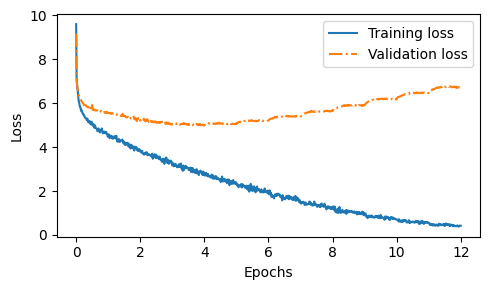

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, train_losses, val_losses)